### Assignment 3 Version 2 

##### Deliar Mohammadi, 30072994
##### John Zheng,30125258
##### Xinzhou Li, 30066080



In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch_optimizer as optim
# from torchsummary import summary
from torchvision.models import resnet50, ResNet50_Weights, ResNet101_Weights, ResNet152_Weights

import PIL
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import random
import os
import glob
from tqdm import tqdm

# Data Classes

In [2]:
class Data():
    def __init__(self, root, paths, labels, transform=None, ext='.jpg'): # move transform into training loop
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.root = root
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label
     
    '''
    get the img,label tuple corresponding to index i
    '''
    def get_no_transform(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        label = self.labels[i] if self.labels else None
        return img, label
    
    '''
    Selects random start point in the dataset and prints 28 images
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self.get_no_transform(i)
            axis.imshow(x[0])
            label = x[1]
            axis.set_xlabel(label)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = (self.get_no_transform(i))[0]
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self)
        avgh = totalh//len(self)
        return avgw, avgh

In [3]:
class TestData():
    def __init__(self, root, paths,transform=None, ext='.jpg'): # move transform into training loop
        self.paths = paths
        self.transform = transform
        self.root = root
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img in index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        img = self.transform(img)
        return img
    
    '''
    predict output for each test image
    '''
    def predict(self, dataloader, model):
        all_preds = torch.Tensor([]).to(device) # specify dtype
        model.eval()
        for batch_index,images in enumerate(dataloader):
            test_images = images.to(device)
            outputs = model(test_images)
            _,preds = torch.max(outputs,1) # calcualtae max in each column (second value=1 for column)
            all_preds = torch.cat((all_preds,preds))
        preds = all_preds.tolist()
        preds = [int(x) for x in all_preds]
        return preds
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def get_no_transform(self, i):
        s = (self.root+'/'+self.paths[i])
        img = Image.open(s)
        return img
    
    '''
    print sample data from test
    '''
    def print_samples(self):
        figure, axes = plt.subplots(1, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self.get_no_transform(i)
            axis.imshow(x)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    write predictions into answer.csv for submission to kaggle
    '''
    def write_predictions(self, predictions, csv_file, output_file):
        file = pd.read_csv(self.root+"/"+csv_file)
        file['Predicted'] = predictions
        file.to_csv(output_file, sep=',', index=False)


# The Model Class

In [4]:
class A3ResNetV2():
    def __init__(self, device):
        self.device = device
        
        self.model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2).to(self.device)
        
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 100),
        )
        
        self.model.fc = self.fc
        self.model.to(self.device)
    
    '''
    freeze all feature layers in the network, does not freeze the fully
    connected layer at the end
    '''
    def freeze_features(self):
        for name,param in self.model.named_parameters():
            if "fc" in name:
                continue
            else:
                param.requires_grad=False
    
    '''
    unfreeze all features, gradient calculates for all conv layers with this called
    '''
    def unfreeze_features(self):
        for param in self.model.parameters():
            param.requires_grad = True
    
    '''
    helper function to check which layers have gradient calculating.
    Yes means its being updated, and No is not updated
    '''
    def print_grad_settings(self):
        for i in self.model.parameters():
            if i.requires_grad==True:
                print("YES")
            else:
                print("NO")
    
    '''
    helper function to print model and summary
    '''
    def print_model(self):
        summary(self.model, (3,224,224))
    
    '''
    function to train the model on a given dataloader,optimizer, and loss function.
    runs for specified number of epochs.
    '''
    def train_model(self, epochs, train_dataloader, optimizer, loss_function, scheduler):
        self.model.train()
        for i in tqdm(range(epochs)):
            
            epoch_loss = 0
            num_examples = 0
            correct_examples = 0
            
            for batch_index,(images,labels) in enumerate(train_dataloader):
                # reset optimizer for the current batch
                optimizer.zero_grad() 
                # load images and labels
                images = images.to(device)
                labels = labels.to(device)
                # calculate output and loss from output
                outputs = self.model(images)
                loss = loss_function(outputs,labels)
                # loss.backward() calculates all gradients for all params, optimizer.step() updates params using our optimizer
                loss.backward()
                optimizer.step()
                # calculate information for this epoch
                epoch_loss += loss.item()*len(labels)
                num_examples += len(labels)
                # calculate predictions and accuracy
                _,preds = torch.max(outputs,1) # calcualtae max in each column (second value=1 for column)
                # print("Preds",preds)
                correct_examples += (preds==labels).sum().item()
            
            # AFTER epoch we calculate accuracy and step scheduler
            train_accuracy = (correct_examples/num_examples)*100
            print(f'Epoch {i}: Training Accuracy: {train_accuracy:.4f}%, Training Loss: {epoch_loss:.4f}')
            scheduler.step()

    '''
    validates model on validation set
    '''
    def validate_model(self, validation_dataloader):
        self.model.eval() 
        num_examples = 0
        correct_examples = 0
        
        for batch_index,(images,labels) in tqdm(enumerate(validation_dataloader)):
            images = images.to(device)
            labels = labels.to(device)
            outputs = self.model(images)
            num_examples += len(labels)
            _ , preds = torch.max(outputs,1)
            # print(preds)
            correct_examples += (preds==labels).sum().item()
            
        validation_accuracy = (correct_examples / num_examples)*100
        print(f'Validation Accuracy: {validation_accuracy:.20f}%')


# Data Preperation

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9,1.3)),
    transforms.ColorJitter(brightness=0.1),
    transforms.ColorJitter(contrast=0.1),
    transforms.ColorJitter(saturation=0.1),
    
    transforms.Resize(size=(224,224)),     
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalized with imagenet mean and std deviation
])

In [6]:
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),     
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Old Resize:
# transforms.Resize(256),
# torchvision.transforms.CenterCrop(224),


##### Load the training and test paths from spreadsheets and setup the data loaders

In [7]:
df_csv = pd.DataFrame(pd.read_csv("./Assignment 3 Dataset/train.csv"))
train_paths = df_csv["id"].to_list()
train_labels = df_csv["label"].to_list()

test_csv = pd.DataFrame(pd.read_csv("./Assignment 3 Dataset/test.csv"))
test_paths = test_csv["id"].values

In [8]:
train_dataset = Data("./Assignment 3 Dataset", train_paths, train_labels, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TestData("./Assignment 3 Dataset", test_paths, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Sampels of training and test data

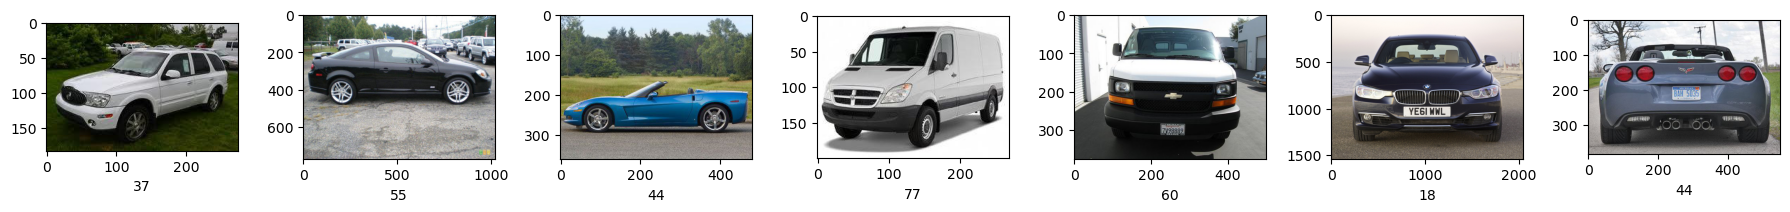

In [9]:
train_dataset.print_samples()

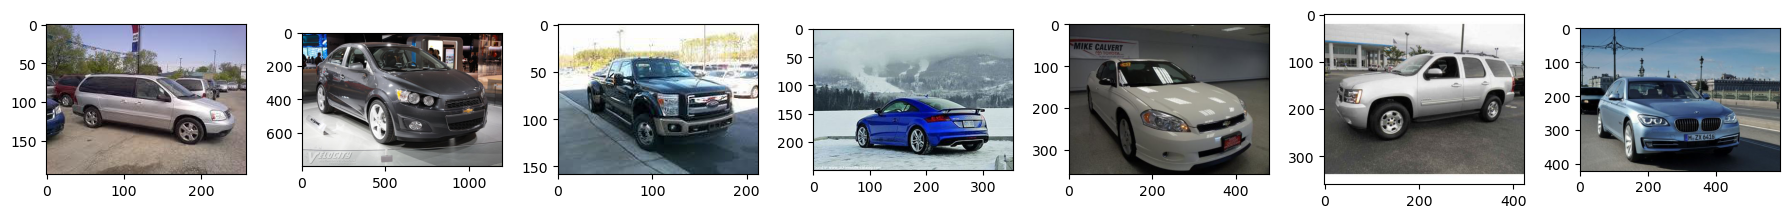

In [10]:
test_dataset.print_samples()

# Instantiating the Model and Making Predictions

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
resnet = A3ResNetV2(device)

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.92)

### Training

To begin training, we will first freeze the feature portion of the network and only train the fully connected layer (classifier) for several epochs.

We will then unfreeze the network and train the entire thing afterwards for many more epochs, and intermittantly make predictions intermitently

In [14]:
resnet.freeze_features()
for i in range(6):
    resnet.train_model(8, train_dataloader, optimizer, loss_function, scheduler)
    
    predictions = test_dataset.predict(test_dataloader, resnet.model) # make predictions on test with current model
    
    out_file_name = "answer_fully_connected"+str(i)+".csv"
    test_dataset.write_predictions(predictions, "/sample.csv", out_file_name) # write predictions to csv

 12%|█▎        | 1/8 [01:28<10:21, 88.85s/it]

Epoch 0: Training Accuracy: 5.3688%, Training Loss: 17841.6180


 25%|██▌       | 2/8 [02:55<08:44, 87.34s/it]

Epoch 1: Training Accuracy: 15.5260%, Training Loss: 14050.3639


 38%|███▊      | 3/8 [04:21<07:15, 87.05s/it]

Epoch 2: Training Accuracy: 25.2237%, Training Loss: 11625.9643


 50%|█████     | 4/8 [05:49<05:49, 87.46s/it]

Epoch 3: Training Accuracy: 33.5429%, Training Loss: 10033.3605


 62%|██████▎   | 5/8 [07:18<04:23, 87.97s/it]

Epoch 4: Training Accuracy: 41.4752%, Training Loss: 8752.6847


 75%|███████▌  | 6/8 [08:47<02:56, 88.25s/it]

Epoch 5: Training Accuracy: 46.5780%, Training Loss: 7936.4927


 88%|████████▊ | 7/8 [10:17<01:28, 88.69s/it]

Epoch 6: Training Accuracy: 52.4063%, Training Loss: 7042.5326


100%|██████████| 8/8 [11:45<00:00, 88.13s/it]

Epoch 7: Training Accuracy: 55.7195%, Training Loss: 6388.8287



 12%|█▎        | 1/8 [01:28<10:18, 88.35s/it]

Epoch 0: Training Accuracy: 59.3954%, Training Loss: 5836.5507


 25%|██▌       | 2/8 [02:55<08:46, 87.83s/it]

Epoch 1: Training Accuracy: 62.9504%, Training Loss: 5353.5270


 38%|███▊      | 3/8 [04:22<07:16, 87.40s/it]

Epoch 2: Training Accuracy: 64.0387%, Training Loss: 5076.4796


 50%|█████     | 4/8 [05:53<05:54, 88.64s/it]

Epoch 3: Training Accuracy: 67.4244%, Training Loss: 4675.2196


 62%|██████▎   | 5/8 [07:20<04:23, 87.99s/it]

Epoch 4: Training Accuracy: 70.3023%, Training Loss: 4302.0497


 75%|███████▌  | 6/8 [08:52<02:58, 89.34s/it]

Epoch 5: Training Accuracy: 72.2128%, Training Loss: 4024.1082


 88%|████████▊ | 7/8 [10:19<01:28, 88.58s/it]

Epoch 6: Training Accuracy: 74.2684%, Training Loss: 3743.0195


100%|██████████| 8/8 [11:45<00:00, 88.21s/it]

Epoch 7: Training Accuracy: 74.8972%, Training Loss: 3666.7565



 12%|█▎        | 1/8 [01:26<10:05, 86.55s/it]

Epoch 0: Training Accuracy: 75.8888%, Training Loss: 3407.1225


 25%|██▌       | 2/8 [02:53<08:41, 86.88s/it]

Epoch 1: Training Accuracy: 77.4607%, Training Loss: 3252.7121


 38%|███▊      | 3/8 [04:20<07:14, 86.81s/it]

Epoch 2: Training Accuracy: 79.3954%, Training Loss: 3091.3119


 50%|█████     | 4/8 [05:47<05:47, 86.79s/it]

Epoch 3: Training Accuracy: 79.2987%, Training Loss: 3064.3814


 62%|██████▎   | 5/8 [07:13<04:20, 86.71s/it]

Epoch 4: Training Accuracy: 81.6445%, Training Loss: 2886.5574


 75%|███████▌  | 6/8 [08:41<02:53, 86.94s/it]

Epoch 5: Training Accuracy: 81.2817%, Training Loss: 2808.7601


 88%|████████▊ | 7/8 [10:08<01:26, 86.95s/it]

Epoch 6: Training Accuracy: 82.9262%, Training Loss: 2614.9719


100%|██████████| 8/8 [11:34<00:00, 86.86s/it]

Epoch 7: Training Accuracy: 82.6844%, Training Loss: 2601.6508



 12%|█▎        | 1/8 [01:26<10:06, 86.62s/it]

Epoch 0: Training Accuracy: 83.5550%, Training Loss: 2530.0646


 25%|██▌       | 2/8 [02:53<08:39, 86.58s/it]

Epoch 1: Training Accuracy: 84.0871%, Training Loss: 2510.3789


 38%|███▊      | 3/8 [04:21<07:16, 87.32s/it]

Epoch 2: Training Accuracy: 84.4015%, Training Loss: 2434.3217


 50%|█████     | 4/8 [05:49<05:51, 87.75s/it]

Epoch 3: Training Accuracy: 84.3047%, Training Loss: 2372.9796


 62%|██████▎   | 5/8 [07:18<04:23, 87.94s/it]

Epoch 4: Training Accuracy: 85.0060%, Training Loss: 2408.9254


 75%|███████▌  | 6/8 [08:46<02:56, 88.00s/it]

Epoch 5: Training Accuracy: 85.7316%, Training Loss: 2258.2811


 88%|████████▊ | 7/8 [10:14<01:28, 88.13s/it]

Epoch 6: Training Accuracy: 86.2878%, Training Loss: 2170.8345


100%|██████████| 8/8 [11:42<00:00, 87.87s/it]

Epoch 7: Training Accuracy: 85.2237%, Training Loss: 2257.2198



 12%|█▎        | 1/8 [01:28<10:16, 88.11s/it]

Epoch 0: Training Accuracy: 85.1995%, Training Loss: 2239.0954


 25%|██▌       | 2/8 [02:56<08:49, 88.25s/it]

Epoch 1: Training Accuracy: 85.7074%, Training Loss: 2180.6841


 38%|███▊      | 3/8 [04:25<07:22, 88.58s/it]

Epoch 2: Training Accuracy: 86.3603%, Training Loss: 2196.5454


 50%|█████     | 4/8 [05:53<05:53, 88.49s/it]

Epoch 3: Training Accuracy: 86.2636%, Training Loss: 2132.2429


 62%|██████▎   | 5/8 [07:22<04:25, 88.59s/it]

Epoch 4: Training Accuracy: 86.5296%, Training Loss: 2094.9005


 75%|███████▌  | 6/8 [08:51<02:57, 88.57s/it]

Epoch 5: Training Accuracy: 86.1911%, Training Loss: 2135.7314


 88%|████████▊ | 7/8 [10:19<01:28, 88.63s/it]

Epoch 6: Training Accuracy: 86.3845%, Training Loss: 2150.1649


100%|██████████| 8/8 [11:48<00:00, 88.58s/it]

Epoch 7: Training Accuracy: 86.4571%, Training Loss: 2067.3054



 12%|█▎        | 1/8 [01:28<10:18, 88.34s/it]

Epoch 0: Training Accuracy: 87.5695%, Training Loss: 1971.6097


 25%|██▌       | 2/8 [02:56<08:50, 88.48s/it]

Epoch 1: Training Accuracy: 87.4970%, Training Loss: 1990.5863


 38%|███▊      | 3/8 [04:25<07:21, 88.32s/it]

Epoch 2: Training Accuracy: 87.1584%, Training Loss: 2022.3458


 50%|█████     | 4/8 [05:52<05:52, 88.07s/it]

Epoch 3: Training Accuracy: 86.8440%, Training Loss: 2029.1501


 62%|██████▎   | 5/8 [07:21<04:24, 88.22s/it]

Epoch 4: Training Accuracy: 88.1016%, Training Loss: 1978.4660


 75%|███████▌  | 6/8 [08:49<02:56, 88.25s/it]

Epoch 5: Training Accuracy: 88.2467%, Training Loss: 1994.2595


 88%|████████▊ | 7/8 [10:18<01:28, 88.35s/it]

Epoch 6: Training Accuracy: 87.1584%, Training Loss: 2002.9527


100%|██████████| 8/8 [11:46<00:00, 88.34s/it]

Epoch 7: Training Accuracy: 88.0532%, Training Loss: 1999.8238


In [15]:
resnet.unfreeze_features()
for i in range(7):
    
    resnet.train_model(8, train_dataloader, optimizer, loss_function, scheduler) # train the model for 9 epochs

    predictions = test_dataset.predict(test_dataloader, resnet.model) # make predictions on test with current model
    
    out_file_name = "answer"+str(i)+".csv"
    test_dataset.write_predictions(predictions, "/sample.csv", out_file_name) # write predictions to csv

 12%|█▎        | 1/8 [01:48<12:41, 108.74s/it]

Epoch 0: Training Accuracy: 88.4160%, Training Loss: 1780.3844


 25%|██▌       | 2/8 [03:37<10:52, 108.83s/it]

Epoch 1: Training Accuracy: 91.4873%, Training Loss: 1346.1606


 38%|███▊      | 3/8 [05:26<09:04, 108.89s/it]

Epoch 2: Training Accuracy: 92.9867%, Training Loss: 1158.2959


 50%|█████     | 4/8 [07:15<07:15, 108.98s/it]

Epoch 3: Training Accuracy: 93.5187%, Training Loss: 1072.3222


 62%|██████▎   | 5/8 [09:04<05:26, 108.85s/it]

Epoch 4: Training Accuracy: 95.1632%, Training Loss: 928.3495


 75%|███████▌  | 6/8 [10:53<03:37, 108.87s/it]

Epoch 5: Training Accuracy: 95.2358%, Training Loss: 887.0210


 88%|████████▊ | 7/8 [12:42<01:48, 108.95s/it]

Epoch 6: Training Accuracy: 95.5985%, Training Loss: 843.0663


100%|██████████| 8/8 [14:31<00:00, 108.99s/it]

Epoch 7: Training Accuracy: 95.3083%, Training Loss: 816.6599



 12%|█▎        | 1/8 [01:55<13:29, 115.65s/it]

Epoch 0: Training Accuracy: 95.9129%, Training Loss: 755.3045


 25%|██▌       | 2/8 [03:50<11:32, 115.42s/it]

Epoch 1: Training Accuracy: 95.8646%, Training Loss: 749.2444


 38%|███▊      | 3/8 [05:45<09:35, 115.12s/it]

Epoch 2: Training Accuracy: 95.7195%, Training Loss: 721.5087


 50%|█████     | 4/8 [07:40<07:40, 115.01s/it]

Epoch 3: Training Accuracy: 96.0822%, Training Loss: 713.2483


 62%|██████▎   | 5/8 [09:35<05:44, 114.96s/it]

Epoch 4: Training Accuracy: 96.7836%, Training Loss: 674.2619


 75%|███████▌  | 6/8 [11:30<03:49, 114.85s/it]

Epoch 5: Training Accuracy: 96.9045%, Training Loss: 611.7798


 88%|████████▊ | 7/8 [13:25<01:54, 114.99s/it]

Epoch 6: Training Accuracy: 96.8803%, Training Loss: 653.7561


100%|██████████| 8/8 [15:19<00:00, 114.89s/it]

Epoch 7: Training Accuracy: 97.0254%, Training Loss: 629.0410



 12%|█▎        | 1/8 [01:50<12:54, 110.61s/it]

Epoch 0: Training Accuracy: 96.8319%, Training Loss: 607.4534


 25%|██▌       | 2/8 [03:41<11:04, 110.72s/it]

Epoch 1: Training Accuracy: 96.9770%, Training Loss: 586.9911


 38%|███▊      | 3/8 [05:40<09:32, 114.46s/it]

Epoch 2: Training Accuracy: 96.9287%, Training Loss: 585.4201


 50%|█████     | 4/8 [07:37<07:41, 115.45s/it]

Epoch 3: Training Accuracy: 97.0979%, Training Loss: 597.3587


 62%|██████▎   | 5/8 [09:34<05:48, 116.01s/it]

Epoch 4: Training Accuracy: 97.1221%, Training Loss: 586.7464


 75%|███████▌  | 6/8 [11:31<03:52, 116.42s/it]

Epoch 5: Training Accuracy: 97.0738%, Training Loss: 588.6877


 88%|████████▊ | 7/8 [13:28<01:56, 116.51s/it]

Epoch 6: Training Accuracy: 97.2430%, Training Loss: 577.6947


100%|██████████| 8/8 [15:25<00:00, 115.63s/it]

Epoch 7: Training Accuracy: 97.1221%, Training Loss: 581.9507



 12%|█▎        | 1/8 [01:57<13:42, 117.51s/it]

Epoch 0: Training Accuracy: 97.2430%, Training Loss: 561.9949


 25%|██▌       | 2/8 [03:52<11:37, 116.24s/it]

Epoch 1: Training Accuracy: 97.4365%, Training Loss: 549.8715


 38%|███▊      | 3/8 [05:43<09:29, 113.80s/it]

Epoch 2: Training Accuracy: 97.5091%, Training Loss: 551.7867


 50%|█████     | 4/8 [07:34<07:30, 112.62s/it]

Epoch 3: Training Accuracy: 97.1947%, Training Loss: 547.5439


 62%|██████▎   | 5/8 [09:25<05:36, 112.05s/it]

Epoch 4: Training Accuracy: 97.3156%, Training Loss: 556.2245


 75%|███████▌  | 6/8 [11:16<03:42, 111.49s/it]

Epoch 5: Training Accuracy: 97.8718%, Training Loss: 519.0977


 88%|████████▊ | 7/8 [13:07<01:51, 111.33s/it]

Epoch 6: Training Accuracy: 97.2430%, Training Loss: 546.6459


100%|██████████| 8/8 [14:57<00:00, 112.16s/it]

Epoch 7: Training Accuracy: 97.1947%, Training Loss: 555.6427



 12%|█▎        | 1/8 [01:50<12:53, 110.47s/it]

Epoch 0: Training Accuracy: 97.4123%, Training Loss: 520.9337


 25%|██▌       | 2/8 [03:41<11:03, 110.65s/it]

Epoch 1: Training Accuracy: 97.4123%, Training Loss: 543.1646


 38%|███▊      | 3/8 [05:32<09:15, 111.09s/it]

Epoch 2: Training Accuracy: 97.5091%, Training Loss: 540.4633


 50%|█████     | 4/8 [07:27<07:29, 112.41s/it]

Epoch 3: Training Accuracy: 97.3881%, Training Loss: 548.8431


 62%|██████▎   | 5/8 [09:18<05:35, 111.92s/it]

Epoch 4: Training Accuracy: 97.4123%, Training Loss: 518.3594


 75%|███████▌  | 6/8 [11:08<03:42, 111.41s/it]

Epoch 5: Training Accuracy: 97.7751%, Training Loss: 510.5580


 88%|████████▊ | 7/8 [12:59<01:51, 111.31s/it]

Epoch 6: Training Accuracy: 97.4123%, Training Loss: 538.5521


100%|██████████| 8/8 [14:50<00:00, 111.34s/it]

Epoch 7: Training Accuracy: 97.7025%, Training Loss: 537.0441



 12%|█▎        | 1/8 [01:50<12:56, 110.96s/it]

Epoch 0: Training Accuracy: 97.3881%, Training Loss: 537.7387


 25%|██▌       | 2/8 [03:41<11:04, 110.82s/it]

Epoch 1: Training Accuracy: 97.6058%, Training Loss: 532.5322


 38%|███▊      | 3/8 [05:32<09:13, 110.79s/it]

Epoch 2: Training Accuracy: 97.3398%, Training Loss: 510.6380


 50%|█████     | 4/8 [07:23<07:23, 110.87s/it]

Epoch 3: Training Accuracy: 97.4849%, Training Loss: 520.4392


 62%|██████▎   | 5/8 [09:13<05:32, 110.71s/it]

Epoch 4: Training Accuracy: 97.9686%, Training Loss: 476.0964


 75%|███████▌  | 6/8 [11:04<03:41, 110.65s/it]

Epoch 5: Training Accuracy: 97.9202%, Training Loss: 495.7365


 88%|████████▊ | 7/8 [12:54<01:50, 110.59s/it]

Epoch 6: Training Accuracy: 97.6300%, Training Loss: 509.5598


100%|██████████| 8/8 [14:45<00:00, 110.68s/it]

Epoch 7: Training Accuracy: 97.8718%, Training Loss: 493.8943



 12%|█▎        | 1/8 [01:50<12:55, 110.84s/it]

Epoch 0: Training Accuracy: 97.7267%, Training Loss: 523.8007


 25%|██▌       | 2/8 [03:41<11:04, 110.81s/it]

Epoch 1: Training Accuracy: 97.5574%, Training Loss: 526.5754


 38%|███▊      | 3/8 [05:36<09:24, 112.81s/it]

Epoch 2: Training Accuracy: 97.7267%, Training Loss: 514.8094


 50%|█████     | 4/8 [07:33<07:37, 114.38s/it]

Epoch 3: Training Accuracy: 97.5333%, Training Loss: 530.5713


 62%|██████▎   | 5/8 [09:29<05:45, 115.04s/it]

Epoch 4: Training Accuracy: 97.5333%, Training Loss: 532.9999


 75%|███████▌  | 6/8 [11:26<03:51, 115.53s/it]

Epoch 5: Training Accuracy: 97.2672%, Training Loss: 514.1563


 88%|████████▊ | 7/8 [13:22<01:55, 115.81s/it]

Epoch 6: Training Accuracy: 97.5816%, Training Loss: 529.1442


100%|██████████| 8/8 [15:18<00:00, 114.86s/it]

Epoch 7: Training Accuracy: 97.8960%, Training Loss: 477.9405


### Sources

https://pytorch.org/vision/stable/models.html

https://discuss.pytorch.org/t/what-does-it-mean-to-normalize-images-for-resnet/96160